In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx

import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np

import gzip
import pickle
import os

try:
    device = torch.device('cuda')
    print("No Cuda Available, Running on CPU")
except:
    print("Running on CPU")

os.environ['TORCH'] = torch.__version__
print(torch.__version__)
###############################################################################
#Some util functions
def visualize_graph(graph, save=False, filename="graph"):
    vis = to_networkx(graph)
    plt.figure(1, figsize=(8, 8))
    nx.draw(vis, cmap=plt.get_cmap('Set3'), node_size=24, linewidths=15)
    if save:
        plt.savefig(f"{filename}.pdf")
    else:
        plt.show()
###############################################################################
train_path='./dataset/train.cpkl.gz'
test_path='./dataset/test.cpkl.gz'

def load_cpkl_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

train_data = load_cpkl_gz(train_path)
test_data = load_cpkl_gz(test_path)
print(list(train_data[1][0].keys()))

No Cuda Available, Running on CPU
2.2.1
['r_vertex', 'l_vertex', 'complex_code', 'l_edge', 'label', 'r_hood_indices', 'r_edge', 'l_hood_indices']


In [29]:
def convert_to_edges_undirected(train_data, protein_loc, side='l'):
    hood_indices_key = f'{side}_hood_indices'
    l_hood_indices = train_data[1][protein_loc][hood_indices_key]
    n_residues = l_hood_indices.shape[0]
    adjacency_matrix = np.zeros((n_residues, n_residues), dtype=int)
    for residue_index in range(n_residues):
        neighbors = l_hood_indices[residue_index, :, 0]
        adjacency_matrix[residue_index, neighbors] = 1
        adjacency_matrix[neighbors, residue_index] = 1

    assert np.all(adjacency_matrix == adjacency_matrix.T), "Adjacency matrix must be symmetric."
    adjacency_matrix_raw = adjacency_matrix.copy()
    
    def make_upper_triangular_zero(matrix):
        upper_triangular_indices = np.triu_indices(matrix.shape[0], k=1)
        matrix[upper_triangular_indices] = 0
        return matrix

    adjacency_matrix = make_upper_triangular_zero(adjacency_matrix)
    edges_array = np.array(adjacency_matrix.nonzero())
    num_cols = edges_array.shape[1]
    edges_undirected = np.zeros((2, 2 * num_cols), dtype=edges_array.dtype)
    for i in range(num_cols):
        edges_undirected[:, 2*i] = edges_array[:, i]
        edges_undirected[:, 2*i+1] = edges_array[::-1, i]

    return edges_array, edges_undirected, adjacency_matrix_raw

def construct_edge_features(edge_array, train_data, protein_loc, side='l'):
    edge_dict = {}
    hood_indices_key = f'{side}_hood_indices'
    edge_key = f'{side}_edge'
    for i in range(edge_array.shape[1]):
        key = tuple(edge_array[:, i])
        parent_residue, chidren_residue = key
        children_search_range = train_data[1][protein_loc][hood_indices_key][parent_residue][:, 0]
        
        search_result = np.where(children_search_range == chidren_residue)
        if len(search_result[0]) == 0:
            parent_residue, chidren_residue = chidren_residue, parent_residue
            children_search_range = train_data[1][protein_loc][hood_indices_key][parent_residue][:, 0]
            search_result = np.where(children_search_range == chidren_residue)
        
        if len(search_result[0]) > 0:
            index = search_result[0][0]
            value = train_data[1][protein_loc][edge_key][parent_residue][index]
            edge_dict[key] = value
        else:
            print(f"No match found for {key}")
        
    edge_dict_final = {key: value.tolist() for key, value in edge_dict.items()}
    edge_features = [item for sublist in list(edge_dict_final.values()) for item in [sublist, sublist]]
    
    return edge_features
###############################################################################
def construct_labels(train_data,protein_loc):
    labels_detail=sorted(train_data[1][protein_loc]['label'].tolist(), key=lambda x: (x[0], x[1]))
    labels=[sublist[2] for sublist in labels_detail]
    return labels,labels_detail
###############################################################################
def construct_nodes(train_data,protein_loc, side='l'):
    vertex_key = f'{side}_vertex'
    return train_data[1][protein_loc][vertex_key].tolist()
###############################################################################
#Example
edge_array, edges_undirected, adjacency_matrix_raw = convert_to_edges_undirected(train_data,protein_loc=0,side='l')
print(edges_undirected)
#Example:
edge_array,edges_undirected, adjacency_matrix_raw= convert_to_edges_undirected(train_data,protein_loc=0,side='l')
edge_features=construct_edge_features(edge_array,train_data,protein_loc=0)
print(edge_features[:8])
#Example:
labels,labels_detail=construct_labels(train_data,protein_loc=0)
print(labels[:8])
print(labels_detail[:8])

[[  1   0   2 ... 182 184 183]
 [  0   1   0 ... 184 183 184]]
[[0.9498680587048166, 1.572864937269464], [0.9498680587048166, 1.572864937269464], [0.8743675395419659, 1.5384204874424303], [0.8743675395419659, 1.5384204874424303], [0.9377461497215888, 1.71037937957326], [0.9377461497215888, 1.71037937957326], [0.7474877025042037, 2.2581386126833345], [0.7474877025042037, 2.2581386126833345]]
[-1, -1, -1, -1, -1, -1, -1, -1]
[[1, 34, -1], [1, 47, -1], [1, 64, -1], [1, 79, -1], [1, 93, -1], [1, 102, -1], [1, 148, -1], [1, 184, -1]]


In [121]:
# Define graph components, an example
x = torch.tensor(construct_nodes(train_data,protein_loc=0, side='l'))

edge_array,edges_undirected,_= convert_to_edges_undirected(train_data,protein_loc=0,side='l')
edge_features=construct_edge_features(edge_array,train_data,protein_loc=0,side='l')
labels,_=construct_labels(train_data,protein_loc=0)

edge_index = torch.tensor(edges_undirected)

edge_attr = torch.tensor(edge_features)

y = torch.tensor(labels)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
print(graph)

#Try graph right components
x = torch.tensor(construct_nodes(train_data,protein_loc=0, side='r'))

edge_array,edges_undirected,_= convert_to_edges_undirected(train_data,protein_loc=0,side='r')
edge_features=construct_edge_features(edge_array,train_data,protein_loc=0,side='r')
labels,_=construct_labels(train_data,protein_loc=0)

edge_index = torch.tensor(edges_undirected)

edge_attr = torch.tensor(edge_features)

y = torch.tensor(labels)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
print(graph)

Data(x=[185, 70], edge_index=[2, 4292], edge_attr=[4292, 2], y=[1683])


In [43]:
#Construct al graphs
def construct_and_save_graphs(train_data, protein_pair, graph_folder_path):
    # Construct right protein graph
    r_edge_array, r_edges_undirected, _ = convert_to_edges_undirected(train_data, protein_loc=protein_pair, side='r')
    r_edge_features = construct_edge_features(r_edge_array, train_data, protein_loc=protein_pair, side='r')
    labels, _ = construct_labels(train_data, protein_loc=protein_pair)
    r_x = torch.tensor(construct_nodes(train_data, protein_loc=protein_pair, side='r'))
    r_edge_index = torch.tensor(r_edges_undirected)
    r_edge_attr = torch.tensor(r_edge_features)
    y = torch.tensor(labels)
    r_graph = Data(x=r_x, edge_index=r_edge_index, edge_attr=r_edge_attr, y=y)

    # Construct left protein graph
    l_edge_array, l_edges_undirected, _ = convert_to_edges_undirected(train_data, protein_loc=protein_pair, side='l')
    l_edge_features = construct_edge_features(l_edge_array, train_data, protein_loc=protein_pair, side='l')
    l_x = torch.tensor(construct_nodes(train_data, protein_loc=protein_pair, side='l'))
    l_edge_index = torch.tensor(l_edges_undirected)
    l_edge_attr = torch.tensor(l_edge_features)
    l_graph = Data(x=l_x, edge_index=l_edge_index, edge_attr=l_edge_attr, y=y)

    # Save the right-protein graph
    r_file_name = "protein_pair_" + str(protein_pair) + "_right.pkl"
    r_file_path = os.path.join(graph_folder_path, r_file_name)
    with open(r_file_path, 'wb') as f:
        pickle.dump(r_graph, f)

    # Save the left-protein graph
    l_file_name = "protein_pair_" + str(protein_pair) + "_left.pkl"
    l_file_path = os.path.join(graph_folder_path, l_file_name)
    with open(l_file_path, 'wb') as f:
        pickle.dump(l_graph, f)

#Usage
GRAGH_FOLDER_PATH = "./constructed_graphs/"
for protein_pair in range(len(train_data[1])):
    construct_and_save_graphs(train_data, protein_pair, GRAGH_FOLDER_PATH)


Data(x=[185, 70], edge_index=[2, 4292], edge_attr=[4292, 2], y=[1683])


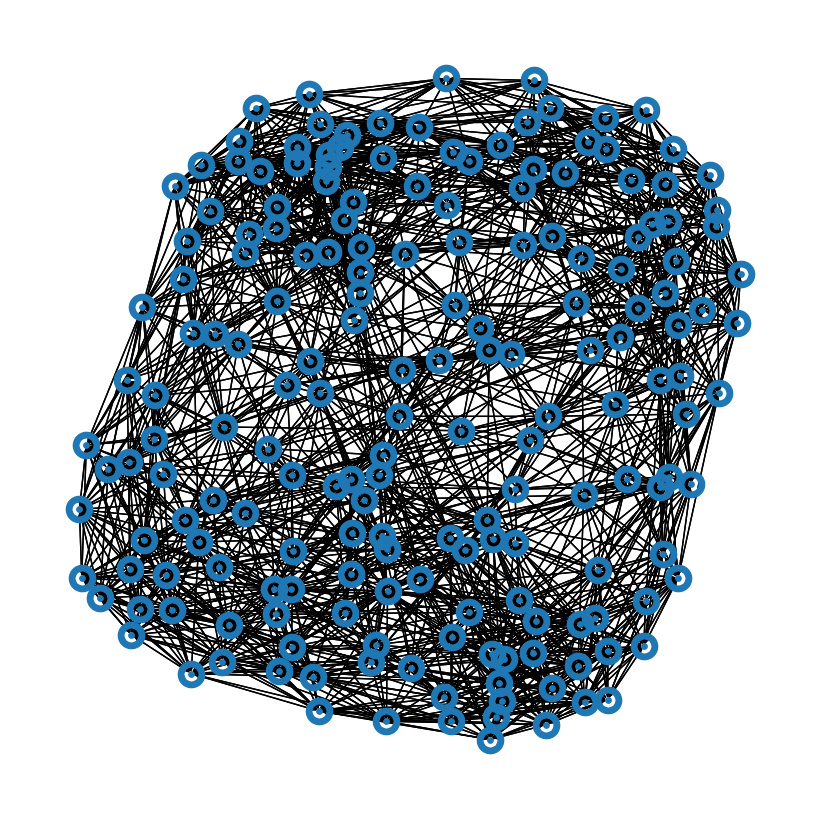

In [126]:
#This is how we get pickle files
with open('./constructed_graphs/protein_pair_0_left.pkl', 'rb') as f:
    graph = pickle.load(f)
print(graph)
visualize_graph(graph,save=True,filename="./Result/Image/protein_pair_0_left")

In [116]:
#Let's pick an example to confirm the graph is correct
print("The 25th right protein 3rd residue should have nodes and features: ",train_data[1][25]['r_vertex'].shape)
print("The 25th right protein 3rd residue top 5 closest neighbor: ",train_data[1][25]['r_hood_indices'][3][:5].reshape(1,-1)[0])
print("Make sure the following edges are contained: (3,2),(3,4),(3,52),(3,5),(3,54)")
print("The 25th right protein (3,1) edge should have edge feature: ",train_data[1][25]['r_edge'][3][0])
#print("Show that the edge feature is correctly assigned")

The 25th right protein 3rd residue should have nodes and features:  (168, 70)
The 25th right protein 3rd residue top 5 closest neighbor:  [ 2  4 52  5 54]
Make sure the following edges are contained: (3,2),(3,4),(3,52),(3,5),(3,54)
The 25th right protein (3,1) edge should have edge feature:  [0.92442314 2.08371661]


In [118]:
with open('./constructed_graphs/protein_pair_25_right.pkl', 'rb') as f:
    graph = pickle.load(f)
print(graph)
edge_index=graph.edge_index
tuple_pairs = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
print((3,1) in tuple_pairs,(3,4) in tuple_pairs,(3,52) in tuple_pairs,(3,5) in tuple_pairs,(3,54) in tuple_pairs)
edge_features=graph.edge_attr
print("edge(3,2)'s feature: ",edge_features[tuple_pairs.index((3, 2))])

Data(x=[168, 70], edge_index=[2, 3970], edge_attr=[3970, 2], y=[1045])
True True True True True
edge(3,2)'s feature:  tensor([0.9244, 2.0837])
